## Applying to YFV Dataset

In [35]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_functions_optSim import *
from scipy import inf
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial
import statsmodels.api as sm

In [36]:
planting(456)

#### *Load Data*

In [37]:
yfv_data = pd.read_table("~/Documents/Computation/Y2/data/processed/yfv-allTime-clean.txt", sep="\t")

Only xclass clonal groups.

In [38]:
yfv_data = yfv_data[yfv_data.IsCrossClass == True] 

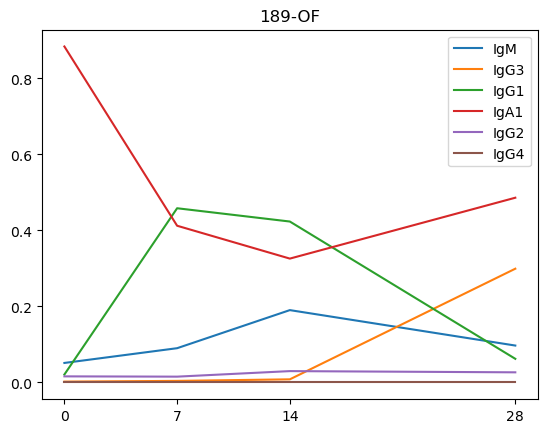

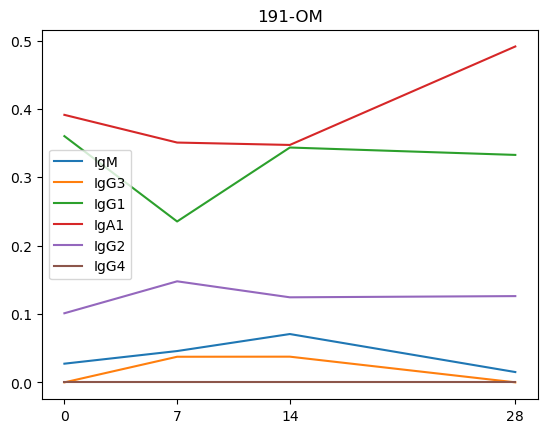

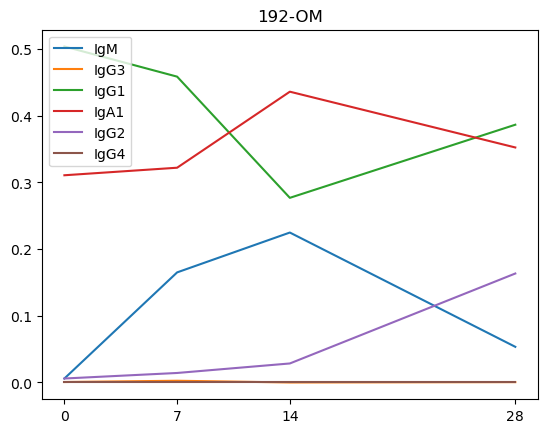

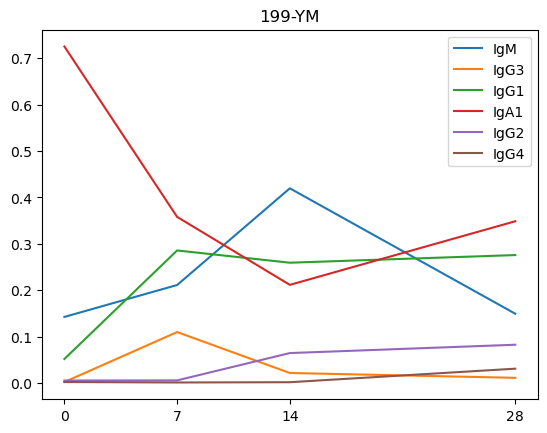

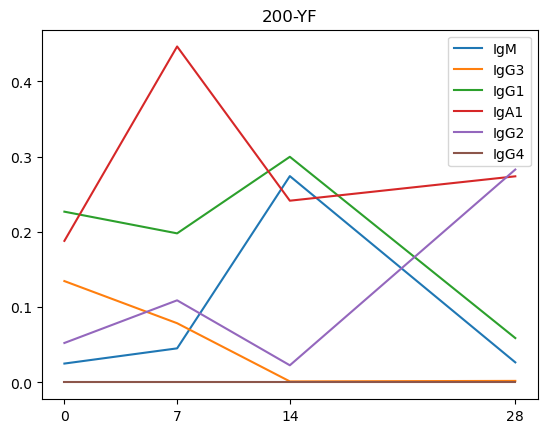

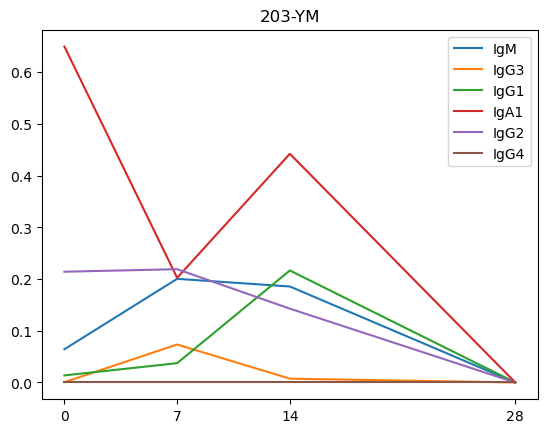

In [39]:
donor_list = yfv_data.PatientID.unique()
timepoint_list = np.sort(yfv_data.TimePoint.unique())
for d in donor_list:
    donor = yfv_data[yfv_data.PatientID == d] 
    
    donor = formatCount(donor, timepoint_list, 'TimePoint', 'Subclass', timemarker='d', isotype_list=['IgM', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgA2'])
    donor = donor.to_numpy()
    
    for i in range(6):
        plt.plot(timepoint_list,donor[i,:], label = ['IgM', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgA2'][i])
        plt.xticks(timepoint_list)
        plt.legend()
    plt.title(d)
    plt.show()


In [40]:
# extract the sampled time points
allD_timepoint_list = np.sort(yfv_data.TimePoint.unique())
allD_T = len(yfv_data.TimePoint.unique())

# transform into state count, there were no ID and IgE so these are not specified
yfv_df = formatCount(yfv_data, allD_timepoint_list, 'TimePoint', 'Subclass', timemarker='d', isotype_list=['IgM', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgA2'])

# transform into nump array for calculations
yfv = yfv_df.to_numpy()

In [41]:
isotype_list = ['IgM', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgA2']

M_donors = {}
N_donors = {}
T_donors = {}
u_donors = {}

donors = yfv_data.PatientID.unique()
timeCourse = {}

for d in donors:
    
    # donor filter
    yfv_donor = yfv_data[yfv_data.PatientID == d]
    
    # extract the sampled time points
    timepoint_list = np.sort(yfv_donor.TimePoint.unique())
    timeCourse[d] = timepoint_list.shape[0] 
    
    # transform into state count
    yfv_donor = formatCount(yfv_donor, timepoint_list, 'TimePoint', 'Subclass', timemarker='d', isotype_list=isotype_list)

    # transform into nump array for calculations
    yfv_donor = yfv_donor.to_numpy()
    
    N, M, T, k = eqTin(yfv_donor, proportion=False)
    
    M_donors[d] = M
    N_donors[d] = N
    T_donors[d] = T
    u_donors[d] = np.diff(timepoint_list)

In [42]:
# set system wide param
k = 7
xterm = 1e-18
gterm = 1e-18
max_iter = 1e5
numCores = 10
theta_initial_ub = 1e-1
mc_iter = 25


n_param = int(k/2 * (k-1))

reg_bounds = def_bounds(n_param, k, account_ingress=False)
reg_con = def_constraints(n_param, k)

optimiserArgs = {'costFunc': calc_S1_donors, 'args': (M_donors, N_donors, T_donors, k, u_donors), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': theta_initial_ub}

theta_allP, optError_allP = parallel_mc_optimiser(mc_iter, numCores, n_param, make_theta0, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)

Optimisation progress:  [================================================] 100%


In [9]:
import pickle
filename = "manuscript_results/yfv_allTime_allDonor.pkl"
with open(filename, 'wb') as f:
    pickle.dump([theta_allP,optError_allP], f)

In [8]:
import pickle
filename = "manuscript_results/yfv_allTime_allDonor.pkl"
with open(filename, 'rb') as f:
    theta_optError = pickle.load(f)
    
theta_allP = theta_optError[0]
optError_allP = theta_optError[1]

In [43]:
N, M, T, k = eqTin(yfv, proportion=False)

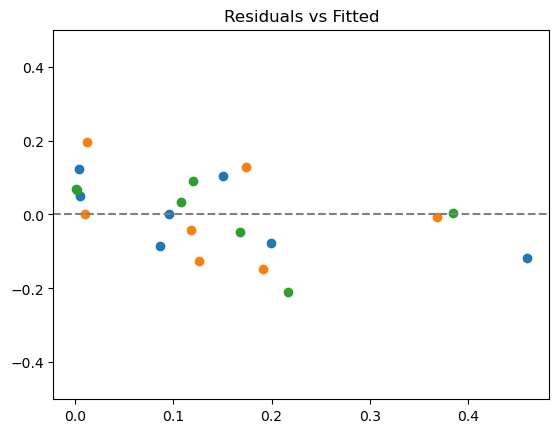

Average abs. residual:  0.08227139025029967


In [44]:
timeCourse = allD_timepoint_list.shape[0] # total timepoints
u = np.diff(allD_timepoint_list) # time interval in days

# residuals
new = theta_allP
S1_Q = theta_to_Q(new, k)

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = N[:,i] - pred[:,(i-1)]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted")
plt.show() 

        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [45]:
pd.DataFrame(S1_Q)

,0,1,2,3,4,5,6
0,-0.333271,0.017308,0.059126,0.070796,0.030821,0.081039,7.418145e-02
1,0.000000,-0.275331,0.089427,0.080697,0.007436,0.078995,1.877629e-02
2,0.000000,0.000000,-0.078160,0.000803,0.052634,0.016469,8.253057e-03
3,0.000000,0.000000,0.000000,-0.005256,0.003874,0.001383,2.254216e-12
4,0.000000,0.000000,0.000000,0.000000,-0.102460,0.070347,3.211338e-02
5,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002126,2.126271e-03
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00


In [48]:
pd.DataFrame(transMat(S1_Q, 1), index=isotype_list, columns=isotype_list)

,IgM,IgG3,IgG1,IgA1,IgG2,IgG4,IgA2
IgM,0.716576,0.012769,0.048879,0.060631,0.026337,0.070849,0.063959
IgG3,0.000000,0.759321,0.075060,0.070380,0.008325,0.069966,0.016949
IgG1,0.000000,0.000000,0.924816,0.000771,0.048092,0.017568,0.008753
IgA1,0.000000,0.000000,0.000000,0.994758,0.003672,0.001509,0.000062
IgG2,0.000000,0.000000,0.000000,0.000000,0.902614,0.066791,0.030595
IgG4,0.000000,0.000000,0.000000,0.000000,0.000000,0.997876,0.002124
IgA2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


(-0.3, 0.3)

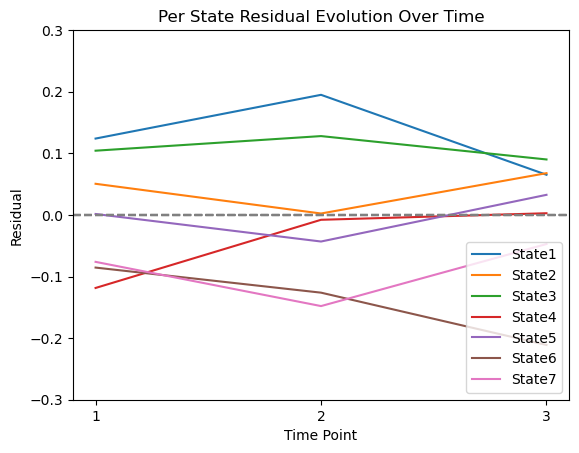

In [49]:
xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = ('State' + str(i+1))); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.title("Per State Residual Evolution Over Time"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.3,.3)

In [31]:
# transform residual vector
Y = np.array([])
X = np.empty((0,2))

for t in range(T-1):
    Y = np.append(Y,epsi[t,:], axis=0)
    time = [t+1]*len(state_list)
    features = np.concatenate((np.array(time).reshape(7,1),np.array(state_list).reshape(7,1)), axis = 1)
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=('TimePoint','State'))
df.TimePoint = df.TimePoint.astype('int64')
df = pd.get_dummies(data=df, drop_first=True)
X = df


NameError: name 'state_list' is not defined

In [ ]:
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

In [10]:
# residuals
S1_Q = theta_to_Q(new, k)
Est_N = pd.DataFrame({'d1': N[:,0]})

for i in range(1,len(timepoint_list)):
    S1_P = transMat(S1_Q, u[i-1])
    
    N_est = Est_N.to_numpy()
    
    # estimate proportions
    prop = np.matmul(S1_P.transpose(),N_est[:,(i-1)]) 
    
    # save out
    day = 'd' + str(timepoint_list[i])
    Est_N[day] = prop

    
Est_N

,d1,d7,d14,d28
0,0.039834,0.030248,0.022969,0.013244
1,0.029462,0.006329,0.001360,0.000063
2,0.241451,0.238121,0.218158,0.176508
3,0.460422,0.419521,0.381653,0.313015
4,0.070676,0.116636,0.144005,0.163537
5,0.000158,0.017743,0.028169,0.037141
6,0.157996,0.171402,0.203687,0.296492


In [11]:
# number of bootstrap samples
B = 500

In [12]:
stateParam = {'state_col_name': 'Subclass', 'numStates': k}
timeParam = {'timemarker': 'd', 'dayColumnName': 'TimePoint', 'timeinterval': u}
isotype_list = ['IgM', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgA2']
mcArgs = {'mciter': mc_iter, 'n_cores': numCores}
optimiserArgs = {'costFunc': calc_S1, 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 10} 
options = {'xterm': xterm, 'max_iter': max_iter}

caseResamp = bootstrap_caseResamp(yfv_data, B, timeParam, n_param, make_theta0, stateParam, isotype_list, mcArgs, optimiserArgs, options)
caseResamp['theta_est'] = theta
caseResamp['optimisationError_atSol'] = optError

/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:398: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:398: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:401: RuntimeWarning: invalid value encountered in matmul
  S1_1 = (N_l - P_l.transpose() @ N_lm1)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/

Compiling results...


In [13]:
residResamp = bootstrap_resResamp(yfv, u, B, n_param, make_theta0, mcArgs, optimiserArgs, options)

Point estimate calculation ...


/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:398: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:398: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:401: RuntimeWarning: invalid value encountered in matmul
  S1_1 = (N_l - P_l.transpose() @ N_lm1)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/

Compiling results...


In [14]:
parametric = bootstrap_parametric(yfv, u, B, n_param, make_theta0, mcArgs, optimiserArgs, options)

Point estimate calculation ...


/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:398: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:401: RuntimeWarning: invalid value encountered in matmul
  S1_1 = (N_l - P_l.transpose() @ N_lm1)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:394: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:398: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:401: RuntimeWarning: invalid value encountered in matmul
  S1_1 = (N_l - P_l.transpose() @ N_lm1)
/home/lservius/D

In [ ]:
import pickle

filename = "manuscript_results/BS_all_YFV.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp, residResamp, parametric], f)

In [ ]:
import pickle

filename = "manuscript_results/BS_all_YFV.pkl"
with open(filename, 'rb') as f:
    caseResamp, residResamp, parametric = pickle.load(f)

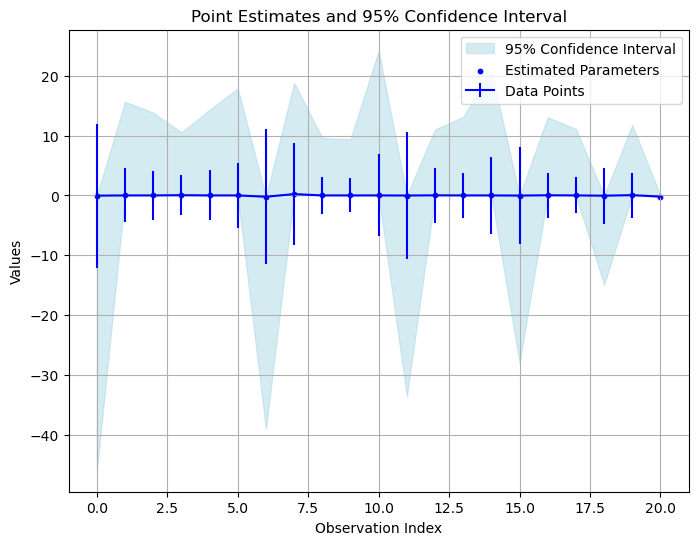

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(caseResamp['theta_est'])), y1=caseResamp['confidenceInterval'][0], y2=caseResamp['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=caseResamp['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Plot the data points
plt.errorbar(x=np.arange(n_param), y=caseResamp['theta_est'], yerr=caseResamp['standardError'], color='blue', label='Data Points')

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

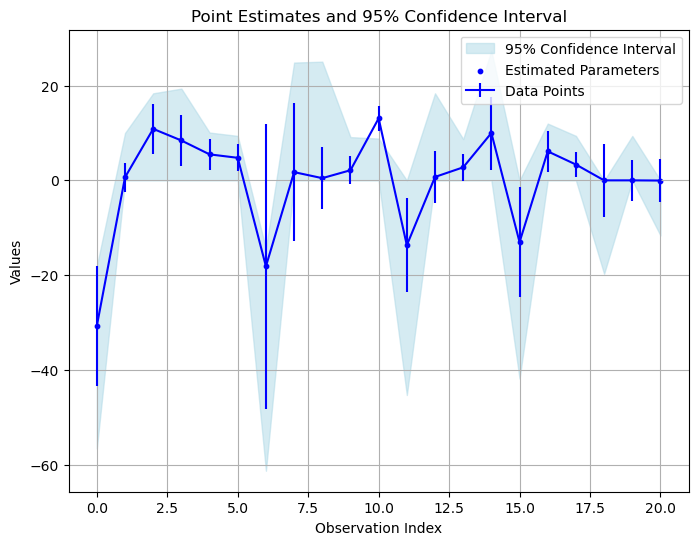

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(residResamp['theta_est'])), y1=residResamp['confidenceInterval'][0], y2=residResamp['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=residResamp['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Plot the data points
plt.errorbar(x=np.arange(n_param), y=residResamp['theta_est'], yerr=residResamp['standardError'], color='blue', label='Data Points')

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

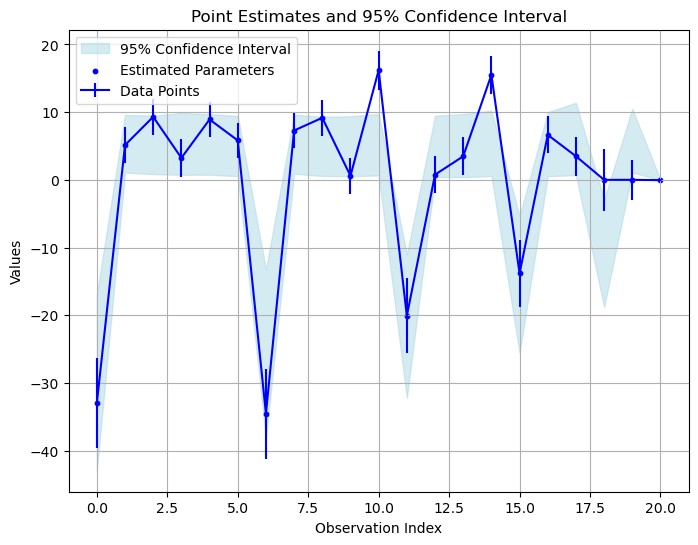

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(parametric['theta_est'])), y1=parametric['confidenceInterval'][0], y2=parametric['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=parametric['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Plot the data points
plt.errorbar(x=np.arange(n_param), y=parametric['theta_est'], yerr=parametric['standardError'], color='blue', label='Data Points')

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

### Error on Transition Matrix

residResample

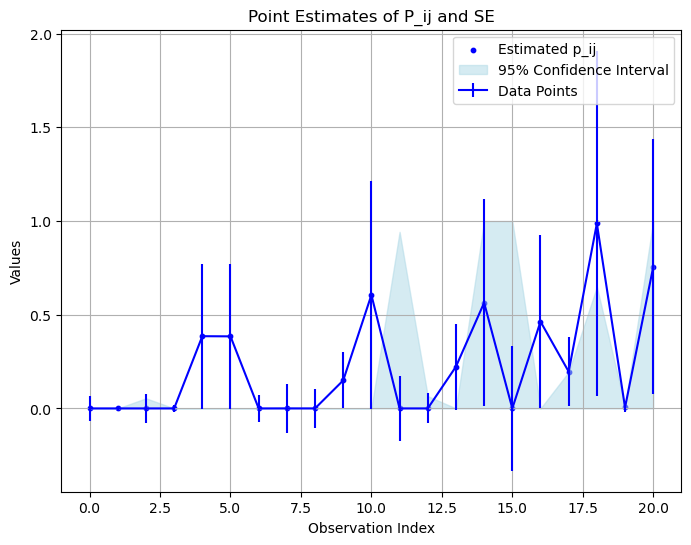

In [ ]:
p_boot = np.zeros((B,n_param))
for i in range(B):
    theta_b = residResamp['bootEstimates'][i,:]
    Q_est = theta_to_Q(theta_b, k)
    P_est = transMat(Q_est,u[0])
    
    p_boot[i,:] = P_est[np.nonzero(Q_est[:,:-1])]
    
p_ij = transMat(theta_to_Q(residResamp['theta_est'],k),u[0])
p_ij = p_ij[np.nonzero(p_ij[:,:-1])]

p_conInt = np.quantile(p_boot,[0.05/2,1-0.05/2], axis=0)

p_SE = np.sqrt( np.sum( ( p_boot - p_ij ) ** 2 , axis=0) * (B - 1)**(-1) )

###

# Create a plot
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(x=np.arange(n_param), y=p_ij, color='blue', label='Estimated p_ij', s = 10)

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(n_param), y1=p_conInt[0], y2=p_conInt[1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.errorbar(x=np.arange(n_param), y=p_ij, yerr=p_SE, color='blue', label='Data Points')

# Customize the plot
plt.title('Point Estimates of P_ij and SE')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

Parametric

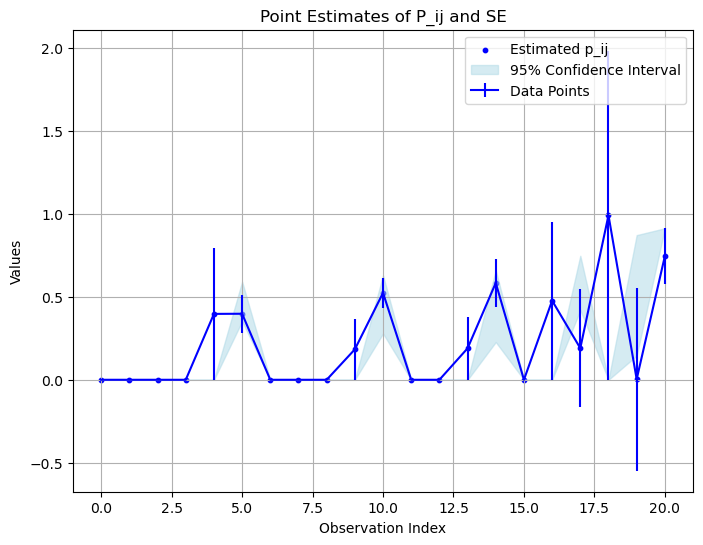

In [ ]:
p_boot = np.zeros((B,n_param))
for i in range(B):
    theta_b = parametric['bootEstimates'][i,:]
    Q_est = theta_to_Q(theta_b, k)
    P_est = transMat(Q_est,u[0])
    
    p_boot[i,:] = P_est[np.nonzero(P_est[:,:-1])]
    
p_ij = transMat(theta_to_Q(parametric['theta_est'],k),u[0])
p_ij = p_ij[np.nonzero(p_ij[:,:-1])]

p_conInt = np.quantile(p_boot,[0.05/2,1-0.05/2], axis=0)

p_SE = np.sqrt( np.sum( ( p_boot - p_ij ) ** 2 , axis=0) * (B - 1)**(-1) )

###

# Create a plot
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(x=np.arange(n_param), y=p_ij, color='blue', label='Estimated p_ij', s = 10)

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(n_param), y1=p_conInt[0], y2=p_conInt[1], color='lightblue', alpha=0.5, label='95% Confidence Interval')


# Plot the data points
plt.errorbar(x=np.arange(n_param), y=p_ij, yerr=p_SE, color='blue', label='Data Points')

# Customize the plot
plt.title('Point Estimates of P_ij and SE')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

In [ ]:
theta_est = residResamp['theta_est']

In [51]:
Q_est = theta_to_Q(theta_est,k)
P_est = pd.DataFrame(transMat(Q_est,u[0]))
P_est

NameError: name 'theta_est' is not defined

In [50]:
# sojourn time

q_ii = np.diagonal(Q_est)

(lambda i: 1/(-q_ii[i]))(range(k))

NameError: name 'Q_est' is not defined